In [4]:
import tensorflow as tf
dim=64
inp_shape=(32,32,3)

In [15]:
#generator model
def generator():
    #preporcess
    input=tf.keras.layers.Input(shape=dim)
    x=tf.keras.layers.Dense(4*4*4*dim)(input)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    #block1
    x=tf.keras.layers.Reshape((4,4,4*dim))(x)
    x=tf.keras.layers.Conv2DTranspose(2*dim,2,strides=2,padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    #block2
    x=tf.keras.layers.Conv2DTranspose(dim,2,strides=2,padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    #deconv
    x=tf.keras.layers.Conv2DTranspose(3,2,strides=2,padding='same')(x)
    x=tf.keras.layers.Activation('tanh')(x)

    return tf.keras.Model(input,x)

model=generator()
model.summary()



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_6 (Dense)             (None, 4096)              266240    
                                                                 
 batch_normalization_6 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        131200    
 ranspose)                                                 

In [22]:
#dicriminator model
def discriminator():
    input=tf.keras.layers.Input(shape=inp_shape)
    x=tf.keras.layers.Conv2D(dim,2,strides=2,padding='same')(input)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Conv2D(2*dim,3,strides=2,padding='same')(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Conv2D(4*dim,3,strides=2,padding='same')(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Flatten()(x)
    x=tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(input,x)

discriminator_model=discriminator()
discriminator_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        832       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 256)         295168    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 4, 4, 256)         0   

In [23]:
#check generator
noise=tf.random.normal([1,dim])
gen_img=model(noise)
gen_img.shape
#discriminator
disc_out=discriminator_model(gen_img)
disc_out

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0006967]], dtype=float32)>

In [48]:
#wgan-gp model
class Wgan(tf.keras.Model):
    def __init__(self,generator,discriminator,dim,gp_weight=10):
        super(Wgan,self).__init__()
        self.generator=generator
        self.discriminator=discriminator
        self.gp_weight=gp_weight
        self.dim=dim
    def compile(self,g_optimizer,d_optimizer,g_loss_fn,d_loss_fn):
        super(Wgan,self).compile()
        self.g_optimizer=g_optimizer
        self.d_optimizer=d_optimizer
        self.g_loss_fn=g_loss_fn
        self.d_loss_fn=d_loss_fn

    def gradient_penalty(self,batch_size,real_img,fake_img):
        alpha=tf.random.normal([batch_size,1,1,1],0.0,1.0)
        interpolated=alpha*real_img+(1-alpha)*fake_img
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            disc_interpolated_out=self.discriminator(interpolated,training=True)
        grads=tape.gradient(disc_interpolated_out,interpolated)
        norm=tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3]))
        gp=tf.reduce_mean((norm-1.)**2)
        return gp

    def train_step(self,real_imgs):
        batch_size=tf.shape(real_imgs)[0]
         # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for _ in range(3):
            random_vec=tf.random.normal(shape=(batch_size,self.dim))
            with tf.GradientTape() as tape:
                fake_imgs=self.generator(random_vec,training=True)
                disc_real_out=self.discriminator(real_imgs,training=True)
                disc_fake_out=self.discriminator(fake_imgs,training=True)
                d_cost=self.d_loss_fn(disc_real_out,disc_fake_out)
                gp=self.gradient_penalty(batch_size,real_imgs,fake_imgs)
                d_cost+=gp*self.gp_weight
            d_gradients=tape.gradient(d_cost,self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradients,self.discriminator.trainable_variables))

        # Train the generator next. The original paper recommends training
        random_vec=tf.random.normal(shape=(batch_size,self.dim))
        with tf.GradientTape() as tape:
            fake_imgs=self.generator(random_vec,training=True)
            disc_fake_out=self.discriminator(fake_imgs,training=True)
            g_cost=self.g_loss_fn(disc_fake_out)
        g_gradients=tape.gradient(g_cost,self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients,self.generator.trainable_variables))
        return {'g_loss':g_cost,'d_loss':d_cost}




       

In [30]:
#define optimizers
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)
# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [49]:
epochs = 20
wgan=Wgan(model,discriminator_model,dim)  
wgan.compile(generator_optimizer,discriminator_optimizer,generator_loss,discriminator_loss)

In [46]:
#load cifar10
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()
x_train=x_train/255.
x_test=x_test/255.
x_train=x_train.reshape(x_train.shape[0],32,32,3).astype('float32')
x_test=x_test.reshape(x_test.shape[0],32,32,3)
#batch
batch_size=64
train_dataset=tf.data.Dataset.from_tensor_slices(x_train).shuffle(x_train.shape[0]).batch(batch_size)

In [50]:
wgan.fit(train_dataset,batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/20
782/782 [==============================] - 37s 42ms/step - g_loss: -15.1890 - d_loss: -14.1466
Epoch 2/20
782/782 [==============================] - 33s 42ms/step - g_loss: -25.2748 - d_loss: -2.5105
Epoch 3/20
782/782 [==============================] - 33s 43ms/step - g_loss: -20.8202 - d_loss: -1.7420
Epoch 4/20
782/782 [==============================] - 34s 43ms/step - g_loss: -21.9991 - d_loss: -1.7309
Epoch 5/20
782/782 [==============================] - 34s 44ms/step - g_loss: -29.1471 - d_loss: -1.5231
Epoch 6/20
782/782 [==============================] - 34s 44ms/step - g_loss: -27.6506 - d_loss: -1.4137
Epoch 7/20
782/782 [==============================] - 34s 44ms/step - g_loss: -26.2633 - d_loss: -1.2953
Epoch 8/20
782/782 [==============================] - 34s 44ms/step - g_loss: -19.6022 - d_loss: -1.3079
Epoch 9/20
782/782 [==============================] - 35s 44ms/step - g_loss: -13.5304 - d_loss: -1.1733
Epoch 10/20
782/782 [==============================] -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


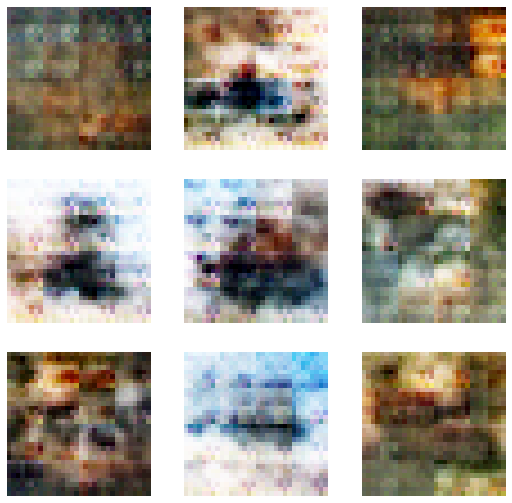

In [52]:
import matplotlib.pyplot as plt
random_latent_vectors = tf.random.normal(shape=(9, dim))
imgs=model(random_latent_vectors)
#display images in 3x3
fig,axes=plt.subplots(3,3,figsize=(9,9))
for i,ax in enumerate(axes.flat):
    ax.imshow(imgs[i].numpy().reshape(32,32,3))
    ax.axis('off')
plt.show()